In [1]:
import h5py
import tensorflow as tf
import numpy as np

from tensorflow.contrib.rnn import LSTMCell
from tensorflow.nn.rnn_cell import MultiRNNCell

In [2]:
batch_size = 200
segment_length = 100
num_features = 1

neurons_per_layer = segment_length
layers = 6
class_n = 5

In [3]:
tf.reset_default_graph()

#defining Inputs
x = tf.placeholder(tf.float32, shape=[batch_size, segment_length, num_features], name = 'x')
sequence_length = tf.placeholder(tf.int32, shape=[batch_size], name = 'sequence_length')

##########################################
## first RNN layers ######################
##########################################

outputs, output_states = tf.nn.bidirectional_dynamic_rnn(
    cell_fw = MultiRNNCell([LSTMCell(neurons_per_layer) for _ in range(layers)]), 
    cell_bw = MultiRNNCell([LSTMCell(neurons_per_layer) for _ in range(layers)]), 
    inputs = x, 
    sequence_length = sequence_length,
    dtype = tf.float32
)

outputs = tf.concat(outputs, 2)
outputs = tf.reshape(outputs, [batch_size, segment_length, 2, neurons_per_layer], name = 'outputs')

#####################################################
## collapse the output of RNN to do further stuff ###
#####################################################

W_collapse = tf.get_variable('W_collapse', shape = [2, neurons_per_layer])
b_collapse = tf.get_variable('b_callapse', shape = [neurons_per_layer])

collapsed = tf.multiply(outputs, W_collapse)
collapsed = tf.reduce_sum(collapsed, axis=2)
collapsed = tf.nn.bias_add(collapsed, b_collapse)
collapsed = tf.reshape(collapsed, [batch_size*segment_length,neurons_per_layer], name = 'collapsed')

###############################
## last NN layer ##############
###############################

W_last = tf.get_variable('W_last', shape = [neurons_per_layer, class_n])
b_last = tf.get_variable('b_last', shape = [class_n])

logits = tf.matmul(collapsed, W_last)
logits = tf.add(logits, b_last)
logits = tf.reshape(logits, [batch_size, segment_length, class_n], name="logits")
print(logits)

Instructions for updating:
seq_dim is deprecated, use seq_axis instead
Instructions for updating:
batch_dim is deprecated, use batch_axis instead
Tensor("logits:0", shape=(200, 100, 5), dtype=float32)


In [4]:
indices = tf.placeholder(tf.int64)
values = tf.placeholder(tf.int32)
dense_shape = tf.placeholder(tf.int64)

labels = tf.SparseTensor(indices = indices, 
                         values = values, 
                         dense_shape = dense_shape
                        )

loss = tf.reduce_mean(
    tf.nn.ctc_loss(labels = labels, 
                   inputs = logits, 
                   sequence_length = sequence_length, 
                   time_major=False
                  )
)

In [5]:
max_steps = 20000
init_rate = 1e-3
global_step = tf.get_variable('global_step', trainable=False, shape=(),
                              dtype=tf.int32,
                              initializer=tf.zeros_initializer())
boundaries = [int(max_steps * 0.66), int(max_steps * 0.83)]
lr_values = [init_rate * decay for decay in [1, 1e-1, 1e-2]]
learning_rate = tf.train.piecewise_constant(global_step, boundaries, lr_values)

optimizer = tf.train.AdamOptimizer(learning_rate)

step = optimizer.minimize(loss, global_step = global_step)

In [6]:
from fast5_input import fast5batches

f5b = fast5batches(batch_size=batch_size, segment_length=segment_length, fast5dir='./', training=True, test_ratio=.2)

checking files: 100%|██████████| 9/9 [00:00<00:00, 2269.37it/s]

1 files have labels, 1 for training and 0 for testing


In [7]:
import datetime
from tqdm import tqdm
start = datetime.datetime.now()

loss_list = []
lr_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for _ in tqdm(range(30)):
        temp = f5b.next_batch(test=False)
        rs, ln, vals, ixs, fi = temp
        feed_dict = {x:rs, sequence_length:ln, indices:ixs, values:vals, dense_shape:rs.shape}
        #if len([x for x in range(batch_size) if x not in np.unique(ixs[0])])>0:
        #    continue
        l, _, lr = sess.run([loss, step, learning_rate], feed_dict = feed_dict)
        loss_list.append(l)
        lr_list.append(lr)
        #print(sess.run(loss, feed_dict = feed_dict))

end = datetime.datetime.now()
print(end-start)

  0%|          | 0/30 [00:00<?, ?it/s]

./IMB14_011406_LT_20170322_FNFAF13375_MN17027_sequencing_run_C4_watermang_22032017_12981_ch78_read10_strand.fast5


 27%|██▋       | 8/30 [00:45<02:04,  5.67s/it]

./IMB14_011406_LT_20170322_FNFAF13375_MN17027_sequencing_run_C4_watermang_22032017_12981_ch78_read10_strand.fast5


 57%|█████▋    | 17/30 [01:34<01:12,  5.59s/it]

./IMB14_011406_LT_20170322_FNFAF13375_MN17027_sequencing_run_C4_watermang_22032017_12981_ch78_read10_strand.fast5


 87%|████████▋ | 26/30 [02:24<00:22,  5.56s/it]

./IMB14_011406_LT_20170322_FNFAF13375_MN17027_sequencing_run_C4_watermang_22032017_12981_ch78_read10_strand.fast5


100%|██████████| 30/30 [02:47<00:00,  5.57s/it]

0:02:47.237803


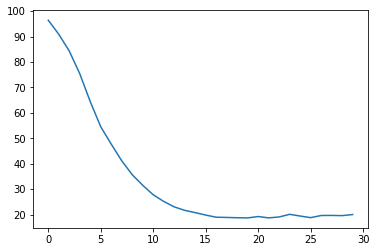

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

plt.plot(loss_list)

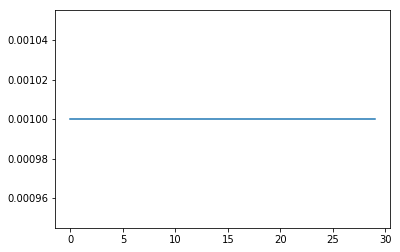

In [9]:
plt.plot(lr_list)

In [10]:
learning_rate

<tf.Tensor 'PiecewiseConstant/case/cond/Merge:0' shape=() dtype=float32>

In [11]:
len(vals), ixs.shape

(2388, (2388, 2))

In [12]:
ln

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

In [13]:
rs.shape

(200, 100, 1)